# Kalman Filter
## David Kartchner
## April 15, 2016

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
from numpy.random import multivariate_normal
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40.0, 20.0)
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24

### Define the Kalman Filter Class

In [2]:
class KalmanFilter(object):
    def __init__(self, F, Q, H, R, u):
        
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        self.w_mean = np.zeros(Q.shape[0])
        self.v_mean = np.zeros(R.shape[0])
        
    def evolve(self, x0, N):
        """
        Compute the first N states and observations generated by the Kalman ←  system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        X = np.empty((4,N)) #states vector
        Z = np.empty((2,N)) #obs vector
        X[:,0] = x0
        Z[:,0] = self.H.dot(x0) + multivariate_normal(self.v_mean, self.R)
        for i in xrange(1, N):
            X[:,i] = F.dot(X[:,i-1]) + self.u + multivariate_normal(self.w_mean, self.Q)
            Z[:,i] = H.dot(X[:,i]) + multivariate_normal(self.v_mean, self.R)
        
        self.states = X
        self.obs = Z
        return X, Z
    
    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        N = z.shape[1]
        n = x.shape[0]
        out = np.empty((n, N))
        out[:,0] = x
            
        I = np.eye(n)
        y = z[:,0] - self.H.dot(x)
        S = self.H.dot(P).dot(self.H.T) + self.R
        K = P.dot(self.H.T).dot(la.inv(S))
        x += K.dot(y)
        P = (I - K.dot(H)).dot(P)
        
        for i in xrange(1,N):
            #Predict
            x = self.F.dot(x) + self.u
            P = self.F.dot(P).dot(self.F.T) + self.Q
            
            #Update
            y = z[:,i] - self.H.dot(x)
            S = self.H.dot(P).dot(self.H.T) + self.R
            K = P.dot(self.H.T).dot(la.inv(S))
            x += K.dot(y)
            P = (I - K.dot(H)).dot(P)
            
            #Put x_k into observation list
            obs[:,i] = x
            
        return obs

    

### Initiate a KalmanFilter object and track its trajectory

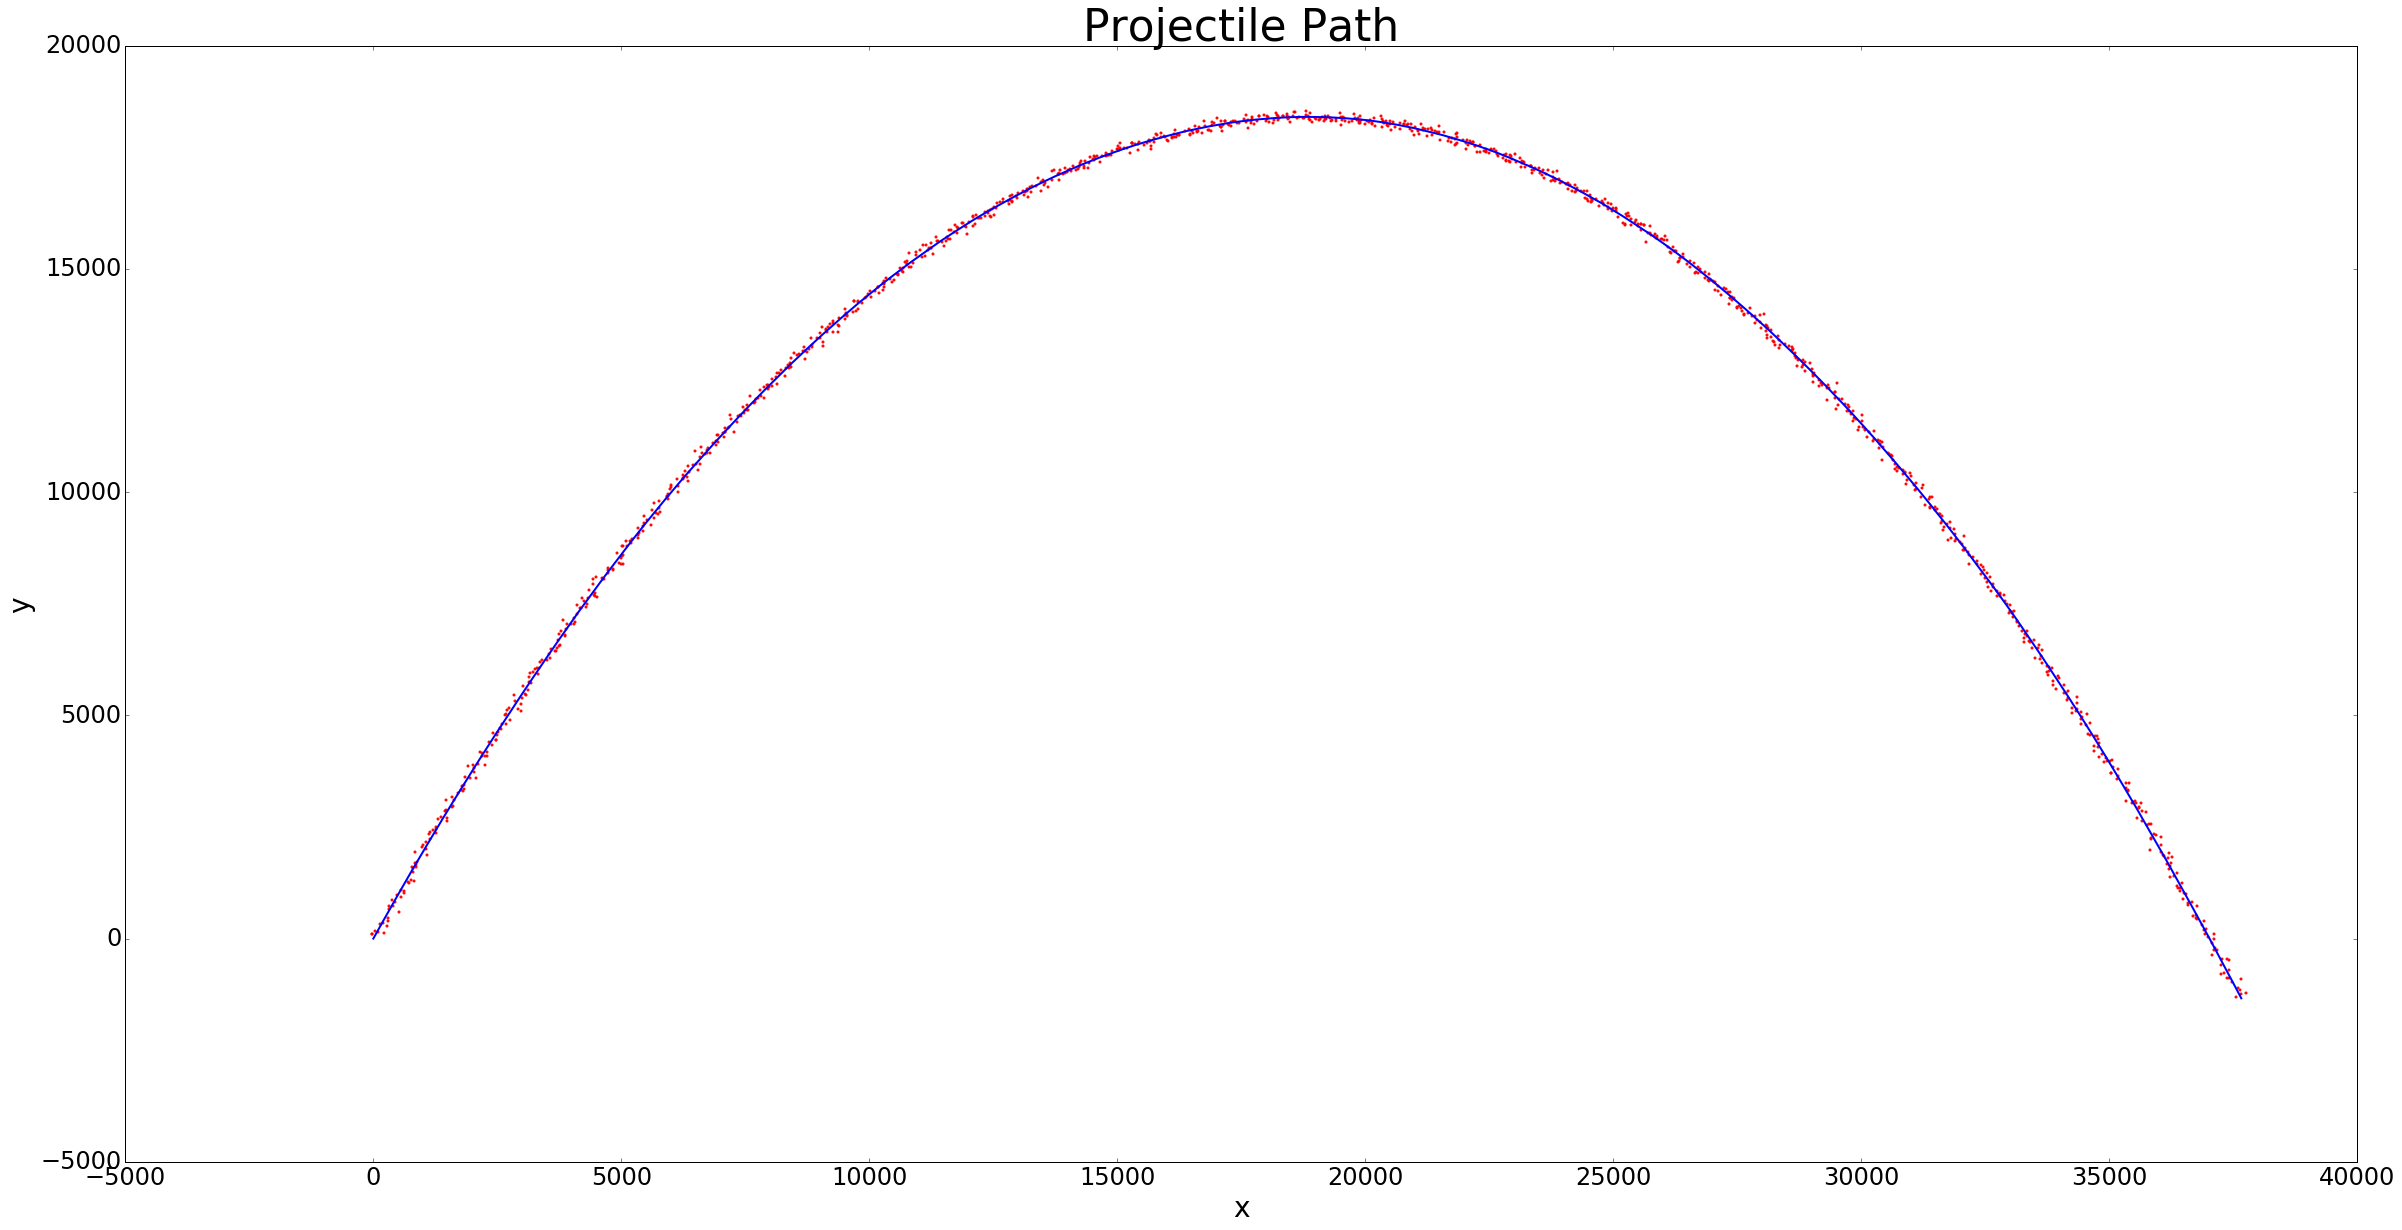

In [3]:
#Define Parameters
Q = .1*np.eye(4)
R = 5000.*np.eye(2)
F = np.array([[1,0,.1,0],[0,1,0,.1],[0,0,1,0],[0,0,0,1]])
u = np.array([0,0,0,-.98])
H = np.array([[1,0,0,0],[0,1,0,0]])
x0 = np.array([0,0,300,600])

#Initialize Kalman Filter Object
KF = KalmanFilter(F, Q, H, R, u)
states, obs = KF.evolve(x0, 1250)

#Plot true and estimated positions
#plt.title("True Projectile Path", fontsize=44)
plt.plot(states[0,:], states[1,:], c='blue', linewidth=2)
plt.xlabel("x", fontsize=28)
plt.ylabel("y", fontsize=28)
#plt.show()

plt.title("Projectile Path", fontsize=44)
plt.scatter(obs[0,:], obs[1,:], s=4, color='red')
#plt.xlabel("x", fontsize=28)
#plt.ylabel("y", fontsize=28)
plt.show()

In [4]:
Z = KF.obs[:,199:800]
P = Q*10**6
xhat = np.empty((4,600))
xhat[:2,0] = Z[:,0]
xhat[2:,0] = np.sum(Z[:,1:9]-Z[:,:8], axis=1)/.8
print xhat[:,0]
print KF.states[:,200]

estimates = KF.estimate(xhat, P, Z)

[  6007.96490797  10119.82108515    388.15057229    274.54520141]
[  6056.98279945  10068.40948761    308.42708643    404.11556072]


ValueError: could not broadcast input array from shape (4,600) into shape (4)